## Klasyfikacja

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import IsolationForest
from scipy.stats import mannwhitneyu, fisher_exact
from statsmodels.stats.multitest import multipletests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    recall_score, precision_score, f1_score, accuracy_score,
    confusion_matrix
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import (
    StratifiedKFold, cross_validate,
    RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_predict
)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from scipy.stats import randint, loguniform, uniform

In [2]:
df = pd.read_csv('RDKit_2D_computed_activity_bin_fin_fp_ready_P28223.csv')

In [3]:
X = df.drop(['activity_bin', 'canonical_smiles'], axis=1, errors='ignore')
y = df['activity_bin']

In [4]:
print(f"Liczba wszystkich próbek: {len(X)}")

Liczba wszystkich próbek: 556


In [5]:
RANDOM_STATE = 123

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=RANDOM_STATE, 
    stratify=y  # Kluczowe! Zachowuje proporcje klas
)

In [7]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print(f"\nPodział zakończony:")
print(f"Treningowy:  {X_train.shape}  ({len(X_train)/len(X)*100:.1f}%)")
print(f"Walidacyjny: {X_val.shape}   ({len(X_val)/len(X)*100:.1f}%)")
print(f"Testowy:     {X_test.shape}   ({len(X_test)/len(X)*100:.1f}%)")


Podział zakończony:
Treningowy:  (389, 208)  (70.0%)
Walidacyjny: (83, 208)   (14.9%)
Testowy:     (84, 208)   (15.1%)


#### Usuwanie zmiennych o zerowej wariancji

In [8]:
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_train)

VarianceThreshold()

In [9]:
cols_keep = X_train.columns[vt.get_support()].tolist()
print(f"Usunięto: {X_train.shape[1] - len(cols_keep)} | zostaje: {len(cols_keep)}")

X_train_f = X_train[cols_keep].copy()
X_val_f   = X_val[cols_keep].copy()
X_test_f  = X_test[cols_keep].copy()

Usunięto: 39 | zostaje: 169


#### Usuwanie zmiennych o wysokiej korelacji

In [10]:
def identify_correlated_cols_train_only(X_train_df: pd.DataFrame, threshold: float = 0.90):
    corr = X_train_df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if (upper[col] >= threshold).any()]
    return to_drop

cols_drop_corr = identify_correlated_cols_train_only(X_train_f, threshold=0.90)
print(f"Znaleziono {len(cols_drop_corr)} cech do usunięcia (korelacje >= 0.90).")

X_train_f = X_train_f.drop(columns=cols_drop_corr)
X_val_f   = X_val_f.drop(columns=cols_drop_corr)
X_test_f  = X_test_f.drop(columns=cols_drop_corr)

Znaleziono 49 cech do usunięcia (korelacje >= 0.90).


In [11]:
print(f"Ostateczny wymiar po czyszczeniu cech: {X_train_f.shape} | val: {X_val_f.shape} | test: {X_test_f.shape}")

Ostateczny wymiar po czyszczeniu cech: (389, 120) | val: (83, 120) | test: (84, 120)


### Wybór istotnych cech

In [12]:
THRESH_MI = 0.05
TOP_N = 10

In [13]:
def is_binary_01(s: pd.Series) -> bool:
    u = pd.unique(s)
    return (u.size <= 2) and np.isin(u, [0, 1]).all()

In [14]:
bin_cols  = [c for c in X_train_f.columns if is_binary_01(X_train_f[c])]
cont_cols = [c for c in X_train_f.columns if c not in bin_cols]

In [15]:
# cechy ciągłe standaryzujemy (tylko na TRAIN)
# binarne zostawiamy 0/1 i oznaczamy jako discrete_features=True
scaler = StandardScaler()
Xtr_cont = scaler.fit_transform(X_train_f[cont_cols])
Xtr_bin  = X_train_f[bin_cols].to_numpy(dtype=float)

feature_order = cont_cols + bin_cols
Xtr_mi = np.hstack([Xtr_cont, Xtr_bin])
discrete_mask = np.array([False]*len(cont_cols) + [True]*len(bin_cols), dtype=bool)

In [16]:
mi_scores = mutual_info_classif(
    Xtr_mi,
    y_train.to_numpy(),
    discrete_features=discrete_mask, # tutaj binarnych nie skalujemy
    random_state=RANDOM_STATE
)

mi_df = (pd.DataFrame({"Feature": feature_order, "MI_Score": mi_scores})
         .sort_values("MI_Score", ascending=False)
         .reset_index(drop=True))
mi_df["Rank"] = np.arange(1, len(mi_df) + 1)

k = int((mi_df["MI_Score"] >= THRESH_MI).sum())
print(f"MI >= {THRESH_MI}: {k} cech z {len(mi_df)}")

MI >= 0.05: 75 cech z 120


#### Wykres łokciowy dla MI

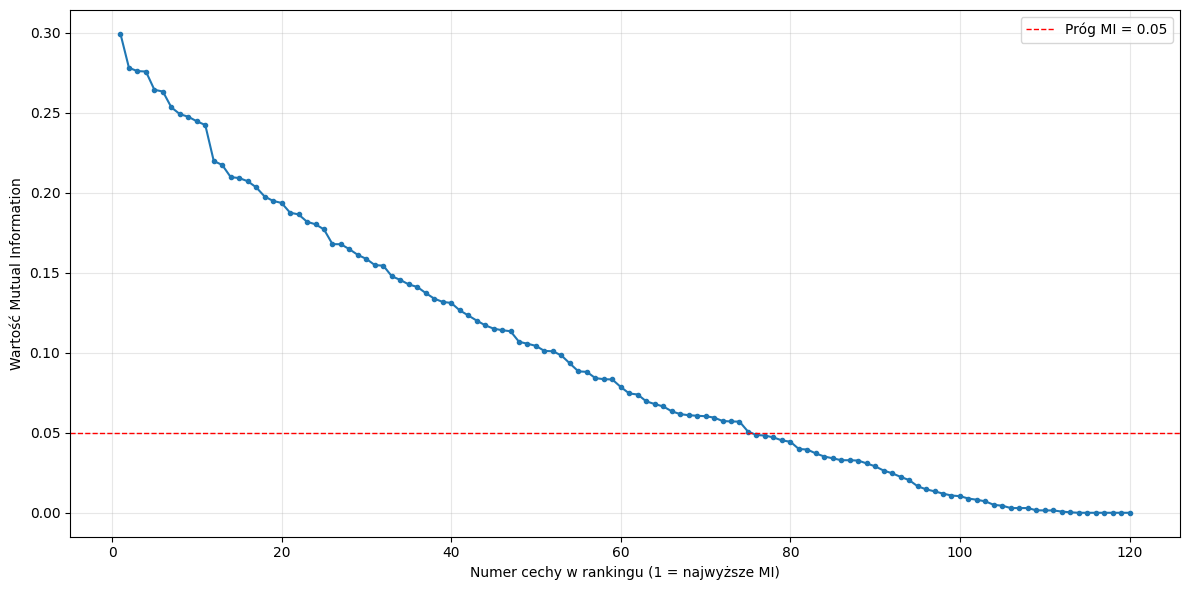

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(mi_df["Rank"], mi_df["MI_Score"], marker="o", linestyle="-", markersize=3)
plt.axhline(THRESH_MI, linestyle="--", linewidth=1, label=f"Próg MI = {THRESH_MI}", color="red")
plt.xlabel("Numer cechy w rankingu (1 = najwyższe MI)")
plt.ylabel("Wartość Mutual Information")
plt.grid(alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("mi_train.png", dpi=400, bbox_inches="tight")
plt.show()

#### Top10 pod względem MI

In [18]:
mi_top10 = mi_df.head(TOP_N).copy()
mi_top10["MI_Score"] = mi_top10["MI_Score"].round(4)

print("\nTop 10 cech wg MI:")
print(mi_top10[["Rank", "Feature", "MI_Score"]].to_string(index=False))


Top 10 cech wg MI:
 Rank          Feature  MI_Score
    1      BCUT2D_MRHI    0.2991
    2 MinPartialCharge    0.2780
    3         BalabanJ    0.2759
    4      BCUT2D_MWHI    0.2756
    5         SMR_VSA7    0.2642
    6 MaxPartialCharge    0.2631
    7            MolWt    0.2533
    8     BCUT2D_MRLOW    0.2490
    9      VSA_EState2    0.2474
   10         SMR_VSA6    0.2446


In [19]:
# kandydaci do testów
cand_feats = mi_df.loc[mi_df["MI_Score"] >= THRESH_MI, "Feature"].tolist()

#### Testy statystyczne (sprawdzamy istotność) dla 75 cech z rankingiem $\geq 0.05$

In [20]:
rows = []
for f in cand_feats:
    if f in bin_cols:
        # Fisher dla 2x2: (cecha binarna) x (y binarne)
        ct = pd.crosstab(X_train_f[f], y_train).reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        _, p = fisher_exact(ct.values, alternative="two-sided")
        test = "fisher"
    else:
        # U Mann–Whitney dla cech ciągłych
        x0 = X_train_f.loc[y_train == 0, f].to_numpy()
        x1 = X_train_f.loc[y_train == 1, f].to_numpy()

        _, p = mannwhitneyu(x0, x1, alternative="two-sided", method="asymptotic")
        test = "mannwhitney"

    rows.append((f, test, p))

test_df = pd.DataFrame(rows, columns=["Feature", "test", "p_value"]).dropna(subset=["p_value"])

In [21]:
# korekcja wielokrotnych porównań - FDR Benjamini–Hochberg
ALPHA_FDR = 0.05

reject, p_adj, _, _ = multipletests(test_df["p_value"].values, alpha=ALPHA_FDR, method="fdr_bh")
test_df["p_adj_fdr"] = p_adj # skorygowane p-value (q-value)
test_df["reject_fdr"] = reject # czy znacząca (True/False)

test_df = test_df.merge(mi_df[["Feature", "MI_Score"]], on="Feature", how="left")

test_df = test_df.sort_values("p_adj_fdr").reset_index(drop=True)

print("Top 15 najmniejszych q-value (p_adj_fdr):")
print(test_df.head(15)[["Feature", "test", "p_value", "p_adj_fdr", "MI_Score"]])

sig_feats = test_df.loc[test_df["reject_fdr"], "Feature"].tolist()
print(f"Istotne po FDR (q<{ALPHA_FDR}): {len(sig_feats)}/{len(test_df)}")

Top 15 najmniejszych q-value (p_adj_fdr):
                     Feature         test       p_value     p_adj_fdr  \
0                   BalabanJ  mannwhitney  5.270748e-31  3.953061e-29   
1                      MolWt  mannwhitney  1.108965e-26  4.158620e-25   
2                        qed  mannwhitney  2.624712e-26  6.561780e-25   
3                  PEOE_VSA2  mannwhitney  6.337211e-26  1.188227e-24   
4                     fr_NH0  mannwhitney  5.172393e-23  7.758589e-22   
5                   SMR_VSA7  mannwhitney  1.450482e-22  1.813103e-21   
6                VSA_EState2  mannwhitney  7.582375e-22  8.123973e-21   
7           FpDensityMorgan1  mannwhitney  4.170376e-21  3.909727e-20   
8                  PEOE_VSA8  mannwhitney  6.269861e-21  5.224885e-20   
9                   SMR_VSA6  mannwhitney  1.423849e-20  1.067887e-19   
10               EState_VSA4  mannwhitney  2.067981e-20  1.409987e-19   
11          fr_unbrch_alkane  mannwhitney  5.445145e-19  3.403216e-18   
12       

#### Lista istotnych cech

In [22]:
sig_feats = test_df.loc[test_df["reject_fdr"], "Feature"].tolist()

print(f"Istotne po FDR (q<{ALPHA_FDR}): {len(sig_feats)}/{len(test_df)}")

print("Wybrane cechy (sig_feats):")
print(sig_feats)

Istotne po FDR (q<0.05): 62/75
Wybrane cechy (sig_feats):
['BalabanJ', 'MolWt', 'qed', 'PEOE_VSA2', 'fr_NH0', 'SMR_VSA7', 'VSA_EState2', 'FpDensityMorgan1', 'PEOE_VSA8', 'SMR_VSA6', 'EState_VSA4', 'fr_unbrch_alkane', 'NumAromaticRings', 'NumSaturatedHeterocycles', 'BCUT2D_CHGLO', 'VSA_EState8', 'TPSA', 'MolLogP', 'SlogP_VSA5', 'NHOHCount', 'SMR_VSA3', 'PEOE_VSA7', 'EState_VSA10', 'SMR_VSA5', 'fr_NH2', 'fr_piperdine', 'MaxPartialCharge', 'PEOE_VSA11', 'SMR_VSA10', 'BCUT2D_MRLOW', 'fr_thiophene', 'EState_VSA8', 'PEOE_VSA5', 'fr_Ndealkylation2', 'EState_VSA3', 'VSA_EState3', 'NumAromaticCarbocycles', 'EState_VSA6', 'NumAromaticHeterocycles', 'SMR_VSA1', 'fr_aniline', 'NumHDonors', 'MaxEStateIndex', 'NumAliphaticHeterocycles', 'MinAbsEStateIndex', 'NumAliphaticRings', 'fr_C_O', 'MinEStateIndex', 'BCUT2D_MRHI', 'VSA_EState4', 'SlogP_VSA3', 'SlogP_VSA8', 'PEOE_VSA3', 'SlogP_VSA10', 'VSA_EState7', 'EState_VSA2', 'PEOE_VSA9', 'EState_VSA5', 'SMR_VSA9', 'VSA_EState1', 'PEOE_VSA6', 'EState_VSA7'

In [23]:
X_train_f = X_train_f[sig_feats]
X_val_f   = X_val_f[sig_feats]
X_test_f  = X_test_f[sig_feats]

print("Po selekcji cech:")
print("train:", X_train_f.shape, "| val:", X_val_f.shape, "| test:", X_test_f.shape)

Po selekcji cech:
train: (389, 62) | val: (83, 62) | test: (84, 62)


## Budowa modeli

In [24]:
X_train_final, y_train_final = X_train_f, y_train
X_val_final,   y_val_final   = X_val_f, y_val
X_test_final,  y_test_final  = X_test_f, y_test

In [25]:
RANDOM_STATE = 123
TARGET_RECALL = 0.90

#### Funkcje pomocnicze

In [26]:
def print_class_balance(y, name=""):
    vc = y.value_counts().sort_index()
    vcp = (y.value_counts(normalize=True).sort_index() * 100).round(2)
    print(f"\nRozkład klas: {name}")
    print(pd.DataFrame({"count": vc, "pct": vcp}))

def cm_active_first(y_true, y_pred):
    # [[TP FN],[FP TN]]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    return np.array([[TP, FN],
                     [FP, TN]])

def plot_cm_active_first(cm_af, save_path, show=False, figsize=(6, 5)):

    cm_af = np.asarray(cm_af)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_af, interpolation="nearest", cmap=plt.cm.Blues, vmin=0)
    fig.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(2),
        yticks=np.arange(2),
        xticklabels=["1", "0"],
        yticklabels=["1", "0"],
        xlabel="Wartość przewidywana",
        ylabel="Wartość rzeczywista"
    )

    thresh = cm_af.max() / 2.0 if cm_af.max() > 0 else 0
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, f"{cm_af[i, j]}",
                ha="center", va="center",
                color="white" if cm_af[i, j] > thresh else "black",
                fontsize=12
            )

    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

def metrics_at_threshold(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)
    cm_af = cm_active_first(y_true, y_pred)
    return {
        "ap": average_precision_score(y_true, y_proba),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "acc": accuracy_score(y_true, y_pred),
        "cm": cm_af
    }

def report_and_save_cm(name, y_true, y_proba, thr, cm_filename, show_cm=False):
    m = metrics_at_threshold(y_true, y_proba, thr)
    print(f"\n[{name}] thr={thr:.4f} | AP={m['ap']:.4f} | recall={m['recall']:.4f} | "
          f"precision={m['precision']:.4f} | f1={m['f1']:.4f} | acc={m['acc']:.4f}")
    print("CM [[TP FN],[FP TN]]:")
    print(m["cm"])
    plot_cm_active_first(m["cm"], save_path=cm_filename, show=show_cm)
    return m

def pick_threshold_pr_curve(y_true, y_proba, target_recall=0.90):
    
    # Dokładny próg z precision_recall_curve:
    # max precision przy recall >= target_recall.
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    prec2, rec2 = prec[:-1], rec[:-1]

    ok = np.where(rec2 >= target_recall)[0]
    if len(ok) == 0:
        i = int(np.argmax(rec2))
        return float(thr[i]), float(prec2[i]), float(rec2[i])

    i = ok[int(np.argmax(prec2[ok]))]
    return float(thr[i]), float(prec2[i]), float(rec2[i])

def threshold_sweep(y_true, y_proba, step=0.05):
    thresholds = np.round(np.arange(0.0, 1.0001, step), 4)
    rows = []
    ap = average_precision_score(y_true, y_proba)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        rows.append({
            "thr": t,
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "acc": accuracy_score(y_true, y_pred)
        })

    df = pd.DataFrame(rows)
    df["ap"] = ap
    return df

def plot_threshold_sweep(df, chosen_thr=None, target_recall=None, save_path=None, show=True):
    plt.figure(figsize=(8, 5))
    plt.plot(df["thr"], df["recall"], label="recall")
    plt.plot(df["thr"], df["precision"], label="precision")
    plt.plot(df["thr"], df["f1"], label="f1")
    plt.plot(df["thr"], df["acc"], label="accuracy")

    if target_recall is not None:
        plt.axhline(target_recall, linestyle="--", linewidth=1, label=f"target recall={target_recall}")

    if chosen_thr is not None:
        plt.axvline(chosen_thr, linestyle="--", linewidth=1, label=f"thr={chosen_thr:.2f}")

    plt.xlabel("Próg")
    plt.ylabel("Wartość metryki")
    plt.legend()
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()


#### Balans klas w każdym ze zbiorów

In [27]:
print_class_balance(y_train_final, "TRAIN")
print_class_balance(y_val_final,   "VAL")
print_class_balance(y_test_final,  "TEST")


Rozkład klas: TRAIN
              count    pct
activity_bin              
0               220  56.56
1               169  43.44

Rozkład klas: VAL
              count    pct
activity_bin              
0                47  56.63
1                36  43.37

Rozkład klas: TEST
              count    pct
activity_bin              
0                48  57.14
1                36  42.86


#### Porównanie kombinacji (balansowanie x model) na bazowych parametrach

In [28]:
cv_sel = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

samplers = {
    "none": None,
    "undersampling": RandomUnderSampler(random_state=RANDOM_STATE),
    "oversampling": RandomOverSampler(random_state=RANDOM_STATE),
}

models = {
    "logistic": LogisticRegression(max_iter=5000, random_state=RANDOM_STATE),
    "svm_rbf": SVC(probability=True, random_state=RANDOM_STATE),
    "naive_bayes": GaussianNB(),
    "random_forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "xgboost": XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric="logloss"),
}

In [29]:
def make_pipe(model_name, model, sampler):
    steps = []
    if model_name in ["logistic", "svm_rbf"]:
        steps.append(("scaler", StandardScaler()))
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model))
    return ImbPipeline(steps)

In [30]:
rows = []
for s_name, sampler in samplers.items():
    for m_name, model in models.items():
        pipe = make_pipe(m_name, model, sampler)
        cv_out = cross_validate(
            pipe,
            X_train_final, y_train_final,
            cv=cv_sel,
            scoring={"ap": "average_precision", "recall": "recall"},
            n_jobs=-1,
            return_train_score=True
        )

        train_ap_mean = np.mean(cv_out["train_ap"])
        val_ap_mean   = np.mean(cv_out["test_ap"])
        train_rec_mean = np.mean(cv_out["train_recall"])
        val_rec_mean   = np.mean(cv_out["test_recall"])

        rows.append({
            "sampler": s_name,
            "model": m_name,
            "train_ap_mean": train_ap_mean,
            "val_ap_mean":   val_ap_mean,
            "val_ap_std":    np.std(cv_out["test_ap"]),
            "ap_gap":        train_ap_mean - val_ap_mean,
            "train_recall_mean": train_rec_mean,
            "val_recall_mean":   val_rec_mean,
            "recall_gap":        train_rec_mean - val_rec_mean,
        })


df_sel = pd.DataFrame(rows).sort_values(
    by=["val_ap_mean", "ap_gap"],
    ascending=[False, True]  # duży AP, mały gap
).reset_index(drop=True)

print("TOP 10 (CV na TRAIN, bazowe parametry) [train vs val fold]:")
print(df_sel.head(10).round(4).to_string(index=False))

TOP 10 (CV na TRAIN, bazowe parametry) [train vs val fold]:
      sampler         model  train_ap_mean  val_ap_mean  val_ap_std  ap_gap  train_recall_mean  val_recall_mean  recall_gap
 oversampling       xgboost         0.9998       0.8643      0.0485  0.1355             0.9970           0.8285      0.1685
         none       xgboost         0.9998       0.8359      0.0650  0.1639             0.9956           0.7932      0.2023
         none random_forest         0.9997       0.8348      0.0751  0.1649             0.9926           0.8111      0.1816
 oversampling random_forest         0.9997       0.8330      0.0488  0.1667             0.9956           0.8228      0.1728
undersampling       xgboost         0.9870       0.8304      0.0631  0.1566             0.9970           0.8285      0.1685
 oversampling      logistic         0.9221       0.8286      0.0611  0.0935             0.9246           0.8465      0.0780
         none      logistic         0.9240       0.8239      0.0693  0.1

#### Wybrano: regresję logistyczną + oversampling jako potencjalnie najlepszą kombinację

#### Wyniki na wybranej kombinacji na bazowych parametrach na zbiorze val (próg wyboru domyślny 0.5)

In [31]:
pipe_lr_over_base = ImbPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

pipe_lr_over_base.fit(X_train_final, y_train_final)
val_proba_lr_base = pipe_lr_over_base.predict_proba(X_val_final)[:, 1]

_ = report_and_save_cm(
    name="LR OVER BASELINE | VAL (thr=0.5)",
    y_true=y_val_final,
    y_proba=val_proba_lr_base,
    thr=0.5,
    cm_filename="cm_lr_baseline_val_thr0p50.png",
    show_cm=False
)


[LR OVER BASELINE | VAL (thr=0.5)] thr=0.5000 | AP=0.7741 | recall=0.8889 | precision=0.7442 | f1=0.8101 | acc=0.8193
CM [[TP FN],[FP TN]]:
[[32  4]
 [11 36]]


#### Tuning hiperparametrów (xgboost+oversampling)

In [32]:
cv_tune = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

tuning_lr = ImbPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE, solver="liblinear"))
])

In [33]:
param_dist_lr = {
    "model__C": loguniform(1e-3, 1e2),
    "model__penalty": ["l2", "l1"],
}

In [34]:
search_lr = RandomizedSearchCV(
    estimator=tuning_lr,
    param_distributions=param_dist_lr,
    n_iter=50,  # wystarczy
    scoring="average_precision",
    refit=True,
    cv=cv_tune,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

#### Wybór najlepszej kombinacji pod względem AP i trening z tymi parametrami na całym trainie

In [35]:
search_lr.fit(X_train_final, y_train_final)
best_params_lr = search_lr.best_params_
print("BEST LR CV AP:", round(search_lr.best_score_, 6))
print("BEST LR PARAMS:", best_params_lr)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits
BEST LR CV AP: 0.82791
BEST LR PARAMS: {'model__C': np.float64(5.724202235542235), 'model__penalty': 'l2'}


In [ ]:
#  kontrola przeuczenia po tuningu (dla wyznaczonych parametrów): train-fold vs val-fold w CV (5x5)
pipe_lr_best = ImbPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE, solver="liblinear"))
]).set_params(**best_params_lr)

cv_check = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

cv_out_lr = cross_validate(
    pipe_lr_best,
    X_train_final, y_train_final,
    cv=cv_check,
    scoring={"ap": "average_precision", "recall": "recall"},
    n_jobs=-1,
    return_train_score=True
)

train_ap = float(np.mean(cv_out_lr["train_ap"]))
val_ap   = float(np.mean(cv_out_lr["test_ap"]))
train_rec = float(np.mean(cv_out_lr["train_recall"]))
val_rec   = float(np.mean(cv_out_lr["test_recall"]))

print("[CV CHECK | LR BEST PARAMS] train-fold vs val-fold:")
print(f" AP:    train={train_ap:.4f} | val={val_ap:.4f} | gap={train_ap - val_ap:.4f}")
print(f" Recall train={train_rec:.4f} | val={val_rec:.4f} | gap={train_rec - val_rec:.4f}")



[CV CHECK | LR BEST PARAMS] train-fold vs val-fold (mean over 5x5):
 AP:    train=0.9444 | val=0.8279 | gap=0.1165
 Recall train=0.9290 | val=0.8354 | gap=0.0936


In [ ]:
# jawny refit
pipe_lr_tuned = ImbPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE, solver="liblinear"))
]).set_params(**best_params_lr)

pipe_lr_tuned.fit(X_train_final, y_train_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sampler', RandomOverSampler(random_state=123)),
                ('model',
                 LogisticRegression(C=np.float64(5.724202235542235),
                                    max_iter=5000, random_state=123,
                                    solver='liblinear'))])

#### Wyniki modelu po tuningu na zbiorze val (próg bazowy 0.5)

In [38]:
val_proba_lr_tuned = pipe_lr_tuned.predict_proba(X_val_final)[:, 1]
_ = report_and_save_cm(
    name="LR OVER TUNED | VAL (thr=0.5)",
    y_true=y_val_final,
    y_proba=val_proba_lr_tuned,
    thr=0.5,
    cm_filename="cm_lr_tuned_val_thr0p50.png",
    show_cm=False
)


[LR OVER TUNED | VAL (thr=0.5)] thr=0.5000 | AP=0.7434 | recall=0.8611 | precision=0.7209 | f1=0.7848 | acc=0.7952
CM [[TP FN],[FP TN]]:
[[31  5]
 [12 35]]


#### Wybór najbardziej optymalnego progu wyboru klasy mniejszościowej (na zbiorze walidacyjnym)

In [39]:
thr_val_lr, prec_val_lr, rec_val_lr = pick_threshold_pr_curve(
    y_val_final, val_proba_lr_tuned, target_recall=TARGET_RECALL
)
print(f"[LR TUNED | VAL] próg z PR-curve: thr={thr_val_lr:.4f} | precision={prec_val_lr:.4f} | recall={rec_val_lr:.4f}")

[LR TUNED | VAL] próg z PR-curve: thr=0.4228 | precision=0.7174 | recall=0.9167


In [40]:
df_val_plot_lr = threshold_sweep(y_val_final, val_proba_lr_tuned, step=0.05)
plot_threshold_sweep(
    df_val_plot_lr,
    chosen_thr=thr_val_lr,
    target_recall=TARGET_RECALL,
    save_path="thresholds_lr_tuned_val.png",
    show=False
)

#### Wyniki modelu po tuningu na zbiorze val przy ustalonym progu

In [41]:
_ = report_and_save_cm(
    name="LR OVER TUNED | VAL (thr z VAL)",
    y_true=y_val_final,
    y_proba=val_proba_lr_tuned,
    thr=thr_val_lr,
    cm_filename="cm_lr_tuned_val_thrVAL.png",
    show_cm=False
)


[LR OVER TUNED | VAL (thr z VAL)] thr=0.4228 | AP=0.7434 | recall=0.9167 | precision=0.7174 | f1=0.8049 | acc=0.8072
CM [[TP FN],[FP TN]]:
[[33  3]
 [13 34]]


#### Wyniki na niezależnym zbiorze testowym modelu po tuningu i przy ustalonym progu

In [42]:
test_proba_lr_tuned = pipe_lr_tuned.predict_proba(X_test_final)[:, 1]
_ = report_and_save_cm(
    name="LR OVER TUNED | TEST (thr z VAL)",
    y_true=y_test_final,
    y_proba=test_proba_lr_tuned,
    thr=thr_val_lr,
    cm_filename="cm_lr_tuned_test_thrVAL.png",
    show_cm=False
)


[LR OVER TUNED | TEST (thr z VAL)] thr=0.4228 | AP=0.8681 | recall=0.9444 | precision=0.6800 | f1=0.7907 | acc=0.7857
CM [[TP FN],[FP TN]]:
[[34  2]
 [16 32]]
